# Decision Tree Analysis

#### DOUBTS:
- Cell with value: 999999999
- Have to normalize? Think not
- About parameters
    - splitter
    - max_features
    - max_leaf_nodes
    - min_impurity_decrease

Importing necessary packages:

In [18]:
import os
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import f1_score
import graphviz
import seaborn as sns

UTILS:

In [5]:
DATABASE_DIR = '/home/macdowell/Workspace/Decision-Tree-Analysis/database/'

def get_entries_name_inside_dir(path):
    smell_folders = os.listdir(path)
    return smell_folders

def dataframe_appended_from_smell_folder(folder_path):
    csv_files = os.listdir(folder_path)
    df = None
    
    for csv in csv_files:
        if 'lock' in csv:
            continue
        
        if df is None:
            df = pd.read_csv(folder_path + '/' + csv)
        else:
            df_aux = pd.read_csv(folder_path + '/' + csv)
            df = pd.concat([df, df_aux])
    return df



### Effectivity on different database's percents:

- RQ1)

In [15]:
def evaluate_model(X, y, df, train_percent):
     # Creating dict to save scores to evaluate:
    f1_scores['DecisionTreeClassifier'] = []
    
    rs = ShuffleSplit(n_splits=5, train_size=train_percent, test_size=0.25)
    for train_index, test_index in rs.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        perform_models(
            [
                DecisionTreeClassifier()
            ],
            X_train, X_test,
            y_train, y_test,
            df,
            train_percent
        )
        

def perform_models(classifiers, X_train, X_test, y_train, y_test, df, train_percent):
    string = ''
    for classifier in classifiers:
        # Creating key index in dict to save evaluation metrics value:
        string += classifier.__class__.__name__

        # Train:
        classifier.fit(X_train, y_train)
        
        #TODO: Make Viz woks
        # Viz:
        '''
        dot_data = tree.export_graphviz(classifier, out_file=None, 
                      feature_names=df.columns,  
                      class_names=['smell', 'not smell'],
                      filled=True, rounded=True,  
                      special_characters=True)  
        graph = graphviz.Source(dot_data)  
        graph
        '''
        
        # Predicting values with model:
        predicteds = classifier.predict(X_test)
        
        # Getting score metrics:
        f1 = f1_score(y_test, predicteds)
        
        # Adding scores:
        f1_scores[classifier.__class__.__name__].append(f1)
    print('train size: ' + str(train_percent))
    print('Average: ' + str(sum(f1_scores['DecisionTreeClassifier'])/len(f1_scores['DecisionTreeClassifier'])))
    print('-----------------------------------------------------------------')
    
f1_scores = {}

smell_folders = get_entries_name_inside_dir(DATABASE_DIR)
train_percents = [0.25, 0.5, 0.75]

for smell in smell_folders:
    smell_metrics_df = dataframe_appended_from_smell_folder(DATABASE_DIR + smell)
    for percent in train_percents:
        #smell_metrics_df = smell_metrics_df.dropna(axis='columns', how='all')
        if '0' in smell_metrics_df.columns:
            smell_metrics_df = smell_metrics_df.drop(columns=['0'], axis=1)

        for c in smell_metrics_df.columns:
            smell_metrics_df[c] = np.nan_to_num(smell_metrics_df[c])

        X = smell_metrics_df.iloc[:, smell_metrics_df.columns != 'Smell']
        y = smell_metrics_df.iloc[:, smell_metrics_df.columns == 'Smell']

        evaluate_model(X, y, smell_metrics_df, percent)

    break

train size: 0.25
Average: 0.41025641025641024
-----------------------------------------------------------------
train size: 0.5
Average: 0.48780487804878053
-----------------------------------------------------------------
train size: 0.75
Average: 0.6315789473684211
-----------------------------------------------------------------


/home/macdowell/Programs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



### PLOT ABOUT RQ1)

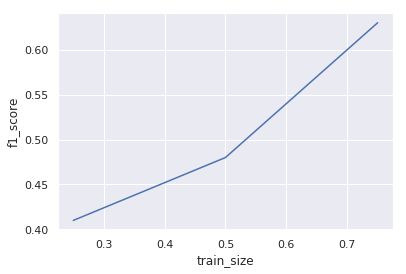

In [32]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
df = pd.read_csv('RQ1.csv')
ax = sns.lineplot(x="train_size", y="f1_score", data=df)

### The maximum depth of the tree:

- RQ2)

### Effectivity on different database's percents with different maximum depth of the tree: